# Orientation maps

This notebook builds a Lissom object (retina+LGN+ReducedLissom), train the network with orientated gaussian inputs, and plots the prefered orientation of the V1 neurons.

In [ ]:
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch

In [ ]:
from pylissom.utils.training import Pipeline
from torch.utils.data import Dataset, DataLoader
from pylissom.datasets.datasets import OrientatedGaussians, ThreeDotFaces

In [ ]:
from pylissom.models.models import get_lissom 
from pylissom.utils.plotting import *
from pylissom.utils.helpers import debug

###### If this takes more than 5 seconds,  it's a problem with the pytorch and cuda versions, only happens first time cuda is called
###### If this takes more than 30 seconds, maybe your cuda is broken

In [ ]:
import torch
foo = torch.Tensor(2)
%time foo.cuda()

## Training variables

The input consists in gaussian oriented images (2 oriented gaussians per picture, in random positions).

In [ ]:
size = 24
count = 10000
epochs = 1
cuda = False
gaussians_per_image = 2

## Init and train Lissom

In [30]:
lissom, optimizer, _ = get_lissom(retinal_density=size, lgn_params='lgn', rlissom_params='rlissom', optim_params='optim')
display(lissom)

Lissom (
  (v1): ReducedLissom (
    (inhibitory_module): Cortex (9216 -> 9216, sigma=47.84, radius=23.0)
    (excitatory_module): Cortex (9216 -> 9216, sigma=7.4879999999999995, radius=9.6)
    (afferent_module): Cortex (576 -> 9216, sigma=5.0, radius=6.5)
    (piecewise_sigmoid): PiecewiseSigmoid (min_theta=0.083, max_theta=0.633)
  , 576 -> 9216, settling_steps=9, afferent_strength=1.0, excitatory_strength=0.9, inhibitory_strength=0.9)
  (off): LGN (
    (diff_of_gaussians): DifferenceOfGaussiansLinear (576 -> 576, sigma_surround=2.0, sigma_center=0.5, radius=9.4, on=False)
    (strength): *2.33
    (piecewise_sigmoid): PiecewiseSigmoid (min_theta=0.0, max_theta=1.0)
  )
  (on): LGN (
    (diff_of_gaussians): DifferenceOfGaussiansLinear (576 -> 576, sigma_surround=2.0, sigma_center=0.5, radius=9.4, on=True)
    (strength): *2.33
    (piecewise_sigmoid): PiecewiseSigmoid (min_theta=0.0, max_theta=1.0)
  )
, 576 -> 9216)

In [ ]:
gaussians_inputs = OrientatedGaussians(size=size, length=count, gaussians=gaussians_per_image)
# gaussians_inputs.cuda()
gaussians_inputs = ThreeDotFaces(size=size, length=count, faces=1)
train_loader = DataLoader(gaussians_inputs, shuffle=True, pin_memory=False)

In [ ]:
sample, test_sample = iter(train_loader).next()

In [ ]:
plot_tensor(sample, shape=(size, size))

In [ ]:
pipe = Pipeline(lissom, optimizer, cuda=cuda, log_interval=10)

## Inpect activation

In [ ]:
gauss, _ = iter(train_loader).next()
plot_tensor(gauss, (size, size), vmin=-1, vmax=1)

In [ ]:
from pylissom.nn.modules.lissom import *
from pylissom.nn.modules import register_recursive_forward_hook, input_output_hook

register_recursive_forward_hook(lissom, input_output_hook)
inp = Pipeline.process_input(torch.autograd.Variable(gauss))
out = lissom(inp)
plot_layer_activation(lissom, 'lissom')

## Train

In [ ]:
pipe.train(train_loader, epoch=0)

## Calculate Orientations Maps
Here we calculate the prefered orientation for each neuron in V1, and plot it with a color encoding. For example, a red color mark a neuron that activates more strongly with horizontal oriented gaussians.

In [ ]:
from pylissom.utils.orientation_maps import *
orientations = 180

keys_arrays = get_oriented_lines(size, orientations=orientations)

In [ ]:
keys_arrays = {k: map(lambda l: torch.autograd.Variable(l.cuda()), lines) for k, lines in keys_arrays.items()}

In [ ]:
om = OrientationMap(model=lissom, inputs=keys_arrays)

orientation_map = om.get_orientation_map()
orientation_hist = om.get_orientation_hist()

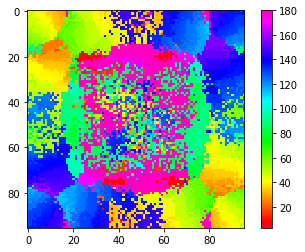

In [40]:
plot_orientation_map(orientation_map)
plt.colorbar()
plt.show()